In [1]:
import pandas as pd
import numpy as np
from openff.toolkit.topology import Molecule
from openff.units import unit
import seaborn as sb
from scipy import stats
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
from openff.recharge.charges.resp import generate_resp_charge_parameter
from openff.recharge.charges.resp.solvers import IterativeSolver
from openff.recharge.grids import GridSettingsType, GridGenerator
from openff.recharge.esp.storage import MoleculeESPRecord
from openff.recharge.grids import LatticeGridSettings
from chargecraft.storage.data_classes import ESPSettings, PCMSettings, DDXSettings

resp_solver = IterativeSolver()

AU_ESP = unit.atomic_unit_of_energy / unit.elementary_charge



def calculate_esp_monopole_au(
    grid_coordinates: unit.Quantity,  # N x 3
    atom_coordinates: unit.Quantity,  # M x 3
    charges: unit.Quantity,  # M
    ):
    """Generate the esp from the on atom monopole
    
    Parameters
    ----------
    grid_coordinates: unit.Quantity
        grid on which to build the esp on 

    atom_coordinates: unit.Quantity
        coordinates of atoms to build the esp  
    
    charges: unit.Quantity
        monopole or charges

    Returns
    -------
    monopole_esp: unit.Quantity
        monopole esp
    """
    #prefactor
    ke = 1 / (4 * np.pi * unit.epsilon_0) # 1/vacuum_permittivity, 1/(e**2 * a0 *Eh)

    #Ensure everything is in AU and correct dimensions
    charges = charges.flatten()
    grid_coordinates = grid_coordinates.reshape((-1, 3)).to(unit.bohr)  #Å to Bohr
    atom_coordinates = atom_coordinates.reshape((-1, 3)).to(unit.bohr)    #Å to Bohr
    #displacement and distance
    displacement = grid_coordinates[:, None, :] - atom_coordinates[None, :, :]  # N x M x 3 B
    distance = np.linalg.norm(displacement.m, axis=-1)*unit.bohr # N, M
    inv_distance = 1 / distance  #N, M

    esp = ke*np.sum(inv_distance * charges[None,:], axis=1)  # (N,M)*(1,M) -> (N,M) numpy broadcasts all charges. Over all atoms  =  Sum over M (atoms), resulting shape: (N,) charges broadcast over each N
    
    return esp.to(AU_ESP)

In [2]:
grid_settings = LatticeGridSettings(
    type="fcc", spacing=0.5, inner_vdw_scale=1.4, outer_vdw_scale=2.0
)

pyrrdine = Molecule.from_smiles('Oc1ccccc1')
pyrrdine.generate_conformers(n_conformers=1)
pyrrdine.assign_partial_charges(partial_charge_method='am1bcc')


In [3]:

grid = GridGenerator.generate(
    molecule=pyrrdine,
    conformer=pyrrdine.conformers[0],
    settings=grid_settings
)

esp = calculate_esp_monopole_au(
    grid_coordinates=grid,
    atom_coordinates= pyrrdine.conformers[0],
    charges=pyrrdine.partial_charges
)


In [4]:
esp

Magnitude,[0.006170545399629076 0.00674799718550885 0.006092551171334265 ... 0.018413543553565222 0.014489503681573042 0.006606364472763173]
Units,hartree/elementary_charge


In [5]:
grid

Magnitude,[[-4.949747468305832 -0.7071067811865476 -1.852818112610613e-15] [-4.949747468305832 -0.35355339059327384 -0.35355339059327556] [-4.949747468305832 -0.35355339059327384 0.3535533905932719] ... [5.303300858899106 0.7071067811865474 -1.060660171779823] [5.303300858899106 0.7071067811865474 -0.35355339059327556] [5.303300858899106 0.7071067811865474 0.3535533905932719]]
Units,angstrom


In [6]:
pyrrdine.conformers[0]

Magnitude,[[2.463419715944672 -0.10487765598825609 0.2195390206204292] [1.0786512307703282 -0.11027977272562108 0.13604127000625854] [0.33297642165985153 -1.2940704027867114 0.16827810683673014] [-1.0279247411300219 -1.1228607295417616 0.07467527068184755] [-1.6459823390504311 0.09790825594317594 -0.04255914856941546] [-0.883419094348185 1.2441175777540947 -0.07131502421550223] [0.47839942384937684 1.1277068769633254 0.018759935644420536] [3.068934549739047 0.06057269143936228 -0.5802943896814868] [0.8392211707552713 -2.2453320976531406 0.2611239057568701] [-1.6316105062651642 -2.018160833830298 0.09665291565168549] [-2.7257530497721105 0.11195332119157657 -0.10886633721824011] [-1.3754329872059472 2.206612344899672 -0.1640261703788477] [1.0285202050533149 2.04671042433458 -0.008009355134773294]]
Units,angstrom


In [7]:
default_settings = ESPSettings(grid_settings = grid_settings)

In [8]:
qc_data_record = MoleculeESPRecord.from_molecule(
    pyrrdine, pyrrdine.conformers[0], grid, esp.reshape(-1,1), None, default_settings
)
resp_charge_parameter = generate_resp_charge_parameter(
    [qc_data_record], resp_solver
)

matchs = pyrrdine.chemical_environment_matches(query=resp_charge_parameter.smiles)
resp_charges = [0.0 for _ in range(pyrrdine.n_atoms)]
for match in matchs:
    for i, atom_indx in enumerate(match):
        resp_charges[atom_indx] = resp_charge_parameter.value[i]

resp_charges


[-0.4830998001982018,
 0.04452726044993888,
 -0.11520837805706753,
 -0.14483266668000752,
 -0.11837200460831844,
 -0.14483266668000752,
 -0.11520837805706753,
 0.4171628882649775,
 0.1273962111539134,
 0.14005582755925228,
 0.1249596681394233,
 0.14005582755925228,
 0.1273962111539134]

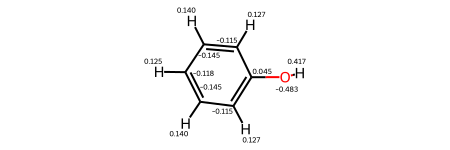

In [9]:
rdkit_pyrridine = pyrrdine.to_rdkit()
for i, atom in enumerate(rdkit_pyrridine.GetAtoms()):
    lbl = '%.3f' % (resp_charges[i])
    atom.SetProp('atomNote', lbl)
rdkit_pyrridine

In [10]:
from chargecraft.storage.storage import MoleculePropRecord, MoleculePropStore

prop_store = MoleculePropStore("/mnt/storage/nobackup/nca121/paper_charge_comparisons/async_chargecraft_more_workers/ESP_rebuilt_2.db", cache_size=1000)
record = next((item for item in prop_store.stream_records(batch_size=5)),None)

In [11]:
openff_mol = Molecule.from_mapped_smiles(record.tagged_smiles, allow_undefined_stereo=True)
openff_mol.add_conformer(record.conformer_quantity)
openff_mol.assign_partial_charges(partial_charge_method='am1bcc')
esp_settings = record.esp_settings
grid = record.grid_coordinates_quantity
esp = record.esp_quantity


In [12]:
esp.shape

(2383, 1)

In [13]:
qc_data_record_off = MoleculeESPRecord.from_molecule(
   molecule= openff_mol,
   conformer = openff_mol.conformers[0],
   grid_coordinates = grid,
   esp = esp,
   electric_field = None,
   esp_settings=esp_settings
)
resp_charge_parameter_2 = generate_resp_charge_parameter(
    [qc_data_record_off], resp_solver
)
matchs = openff_mol.chemical_environment_matches(query=resp_charge_parameter_2.smiles)
resp_charges = [0.0 for _ in range(openff_mol.n_atoms)]
for match in matchs:
    for i, atom_indx in enumerate(match):
        resp_charges[atom_indx] = resp_charge_parameter_2.value[i]

resp_charges

[-0.0740037026202387,
 0.012614062918434452,
 -0.2652861266023892,
 0.09562053309880732,
 -0.31386666533972685,
 0.05558009793227767,
 -0.5953572536463835,
 0.0989065336435898,
 0.0989065336435898,
 0.08607868842758523,
 0.08607868842758523,
 0.14591287814513396,
 0.07371458584264005,
 0.07371458584264005,
 0.42138656028645477]

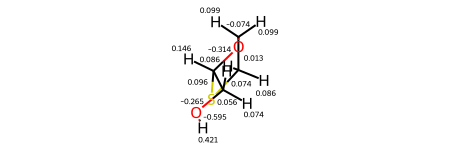

In [14]:
rdkit_openff_mol = openff_mol.to_rdkit()
for i, atom in enumerate(rdkit_openff_mol.GetAtoms()):
    lbl = '%.3f' % (resp_charges[i])
    atom.SetProp('atomNote', lbl)
rdkit_openff_mol

In [15]:
from ChargeAPI.API_infrastructure.esp_request.module_version_esp import handle_esp_request
from rdkit.Chem import rdmolfiles

pyrr_molblock = rdmolfiles.MolToMolBlock(rdkit_pyrridine)